<a href="https://colab.research.google.com/github/ranjans109340734/CSCI5593_ranjans/blob/master/Music_Genre_Classification_CNN_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%matplotlib inline
%tensorflow_version 1.x
import numpy as np
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.optimizers import Adam, RMSprop
from keras import regularizers
from keras.utils import np_utils,to_categorical

Using TensorFlow backend.


In [0]:
def get_audio_path(audio_dir, track_id):
    track_id=str(track_id).zfill(6)
    return os.path.join(audio_dir, track_id[:3],track_id + '.mp3')

def get_tids_from_directory(audio_dir):
    tids = []
    for root, dirs, files in os.walk(audio_dir):
        if dirs == []:
            tids.extend(int(file[:-4]) for file in files)
    return tids

AUDIO_DIR='/content/drive/My Drive/DP_Project/fma_small'

In [0]:
def create_spectogram(track_id):
    filename = get_audio_path(AUDIO_DIR, track_id)
    y, sr = librosa.load(filename)
    spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    return spect.T

In [0]:
filepath = '/content/drive/My Drive/DP_Project/fma_metadata/tracks.csv'
tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])
keep_cols = [('set', 'split'),('set', 'subset'),('track', 'genre_top')]

df_all = tracks[keep_cols]
df_all = df_all[df_all[('set', 'subset')] == 'small']

df_all['track_id'] = df_all.index

dict_genres = {'Electronic':1, 'Experimental':2, 'Folk':3, 'Hip-Hop':4, 
               'Instrumental':5,'International':6, 'Pop' :7, 'Rock': 7  }

In [0]:
def create_array(dataframe):
    genres = []
    X_spect = np.empty((0, 640, 128))
    count = 0
    #errors handling in case of faulty music file 
    for index, row in dataframe.iterrows():
        try:
            count += 1
            track_id = int(row['track_id'])
            genre = str(row[('track', 'genre_top')])
            spect = create_spectogram(track_id)

            # Normalize for small shape differences
            spect = spect[:640, :]
            X_spect = np.append(X_spect, [spect], axis=0)
            genres.append(dict_genres[genre])

        except:
            print("Couldn't process: ", count)
            continue
    y_arr = np.array(genres)
    return X_spect, y_arr

In [7]:
df_train = df_all[df_all[('set', 'split')]=='training']
df_valid = df_all[df_all[('set', 'split')]=='validation']
df_test = df_all[df_all[('set', 'split')]=='test']

X_test, y_test = create_array(df_test)
np.savez('test_arr', X_test, y_test)
X_valid, y_valid = create_array(df_valid)
np.savez('valid_arr', X_valid, y_valid)

Couldn't process:  681


In [8]:
def splitDataFrameIntoSmaller(df, chunkSize = 1600): 
    listOfDf = list()
    numberChunks = len(df) // chunkSize + 1
    for i in range(numberChunks):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
    return listOfDf

listDf = splitDataFrameIntoSmaller(df_train)
df1_train = listDf[0]
df2_train = listDf[1]
df3_train = listDf[2]
df4_train = listDf[3]

X_train1, y_train1 = create_array(df1_train)
np.savez('train1_arr', X_train1, y_train1)
X_train2, y_train2 = create_array(df2_train)
np.savez('train2_arr', X_train2, y_train2)
X_train3, y_train3 = create_array(df3_train)
np.savez('train3_arr', X_train3, y_train3)
X_train4, y_train4 = create_array(df4_train)
np.savez('train4_arr', X_train4, y_train4)

Couldn't process:  1285
Couldn't process:  1467
Couldn't process:  296
Couldn't process:  297
Couldn't process:  298
Couldn't process:  331
Couldn't process:  698
Couldn't process:  806
Couldn't process:  812


In [0]:
npzfile = np.load('train1_arr.npz')
X_train1 = npzfile['arr_0']
y_train1 = npzfile['arr_1']


npzfile = np.load('train2_arr.npz')
X_train2 = npzfile['arr_0']
y_train2 = npzfile['arr_1']

npzfile = np.load('train3_arr.npz')
X_train3 = npzfile['arr_0']
y_train3 = npzfile['arr_1']

npzfile = np.load('train4_arr.npz')
X_train4 = npzfile['arr_0']
y_train4 = npzfile['arr_1']


npzfile = np.load('valid_arr.npz')
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']

In [0]:
X_train = np.concatenate((X_train1, X_train2, X_train3, X_train4), axis = 0)
y_train = np.concatenate((y_train1, y_train2, y_train3, y_train4), axis = 0)

## Convert y data from scale 0-7
y_train = y_train -1
y_valid = y_valid -1

### Convert the scale of training data
X_train_raw = librosa.core.db_to_power(X_train, ref=1.0)

X_train_log = np.log(X_train_raw)

X_valid_raw = librosa.core.db_to_power(X_valid, ref=1.0)
X_valid_log = np.log(X_valid_raw)


def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X_train, y_train = unison_shuffled_copies(X_train_log, y_train)
X_valid, y_valid = unison_shuffled_copies(X_valid_log, y_valid)

y_train=to_categorical(y_train)
y_valid=to_categorical(y_valid)


np.savez('shuffled_train', X_train, y_train)
np.savez('shuffled_valid', X_valid, y_valid)

In [11]:
npzfile = np.load('shuffled_train.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)


npzfile = np.load('shuffled_valid.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(6391, 640, 128) (6391, 7)
['arr_0', 'arr_1']
(799, 640, 128) (799, 7)


**CNN RNN MODEL**

In [0]:
batch_size = 32
num_classes = 7
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [0]:
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
EPOCH_COUNT = 70
NUM_HIDDEN = 64
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### 3 1D Convolution Layers
    for i in range(N_LAYERS):
        # give name to the layers
        layer = Conv1D(
                filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization),  # Tried 0.001
                name='convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.4)(layer)
    
    ## LSTM Layer
    layer = LSTM(LSTM_COUNT, return_sequences=False)(layer)
    layer = Dropout(0.4)(layer)
    
    ## Dense Layer
    layer = Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
    layer = Dropout(0.4)(layer)
    
    ## Softmax Output
    layer = Dense(num_classes)(layer)
    print(layer.shape)
    layer = Activation('softmax', name='output_realtime')(layer)
    print(layer.shape)
    model_output = layer
    model = Model(model_input, model_output)
    
    
    opt = Adam(lr=0.001)
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [0]:
def train_model(x_train, y_train, x_val, y_val):    
    n_features = x_train.shape[2]
    input_shape = (None, n_features)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('/content/drive/My Drive/DP_Project/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history

In [0]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [19]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)

Building model...
(?, 7)
(?, 7)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 128)         0         
_________________________________________________________________
convolution_1 (Conv1D)       (None, None, 56)          35896     
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 56)          224       
_________________________________________________________________
activation_4 (Activation)    (None, None, 56)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 56)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 56)          0         
_________________________________________________________________
convolution_2 (Conv1D)     

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


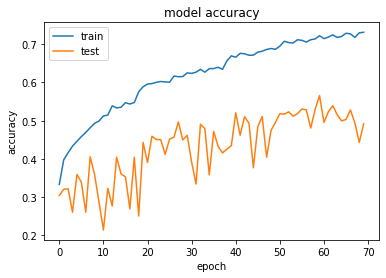

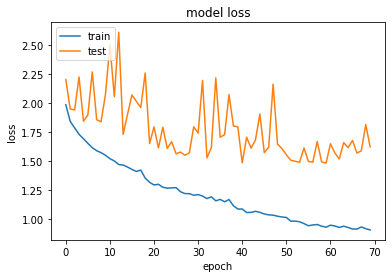

In [20]:
show_summary_stats(history)

In [25]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'New' :6, 'Rock': 6  }
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,6]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred))

(799,) (799,)
              precision    recall  f1-score   support

           0       0.46      0.46      0.46       100
           1       0.53      0.31      0.39       100
           2       0.75      0.40      0.52       100
           3       0.63      0.40      0.49       100
           4       0.46      0.31      0.37        99
           5       0.47      0.67      0.55       100
           6       0.44      0.69      0.54       200

    accuracy                           0.49       799
   macro avg       0.54      0.46      0.48       799
weighted avg       0.52      0.49      0.48       799



In [26]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.4918648310387985


In [0]:
from keras.models import load_model

weights_path = '/content/drive/My Drive/DP_Project/weights.best.h5'
model = load_model(weights_path)

In [29]:
npzfile = np.load('test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [30]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

0 6 3.375


In [31]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1e-08 1.0 0.004623813486211768


In [33]:
X_test = np.log(X_test_raw)


from sklearn.metrics import classification_report

y_true = y_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred))

(800,) (800,)
              precision    recall  f1-score   support

           0       0.68      0.41      0.51       100
           1       0.27      0.28      0.28       100
           2       0.18      0.26      0.22       100
           3       0.66      0.84      0.74       100
           4       0.43      0.28      0.34       100
           5       0.52      0.46      0.49       100
           6       0.58      0.62      0.60       200

    accuracy                           0.47       800
   macro avg       0.48      0.45      0.45       800
weighted avg       0.49      0.47      0.47       800



In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

print(confusion_matrix(y_true, y_pred))

[[ 41   2   7  11   4  13  22]
 [  4  28  16   7  12  10  23]
 [  1  35  26   0  15   5  18]
 [  3   3   1  84   0   3   6]
 [  2  19  37   1  28   4   9]
 [  3   1  28   7   2  46  13]
 [  6  14  26  18   4   7 125]]
